In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

# Memuat dan memproses data

In [56]:
filename = 'data/data_balita.csv'

# Membaca data dari file CSV

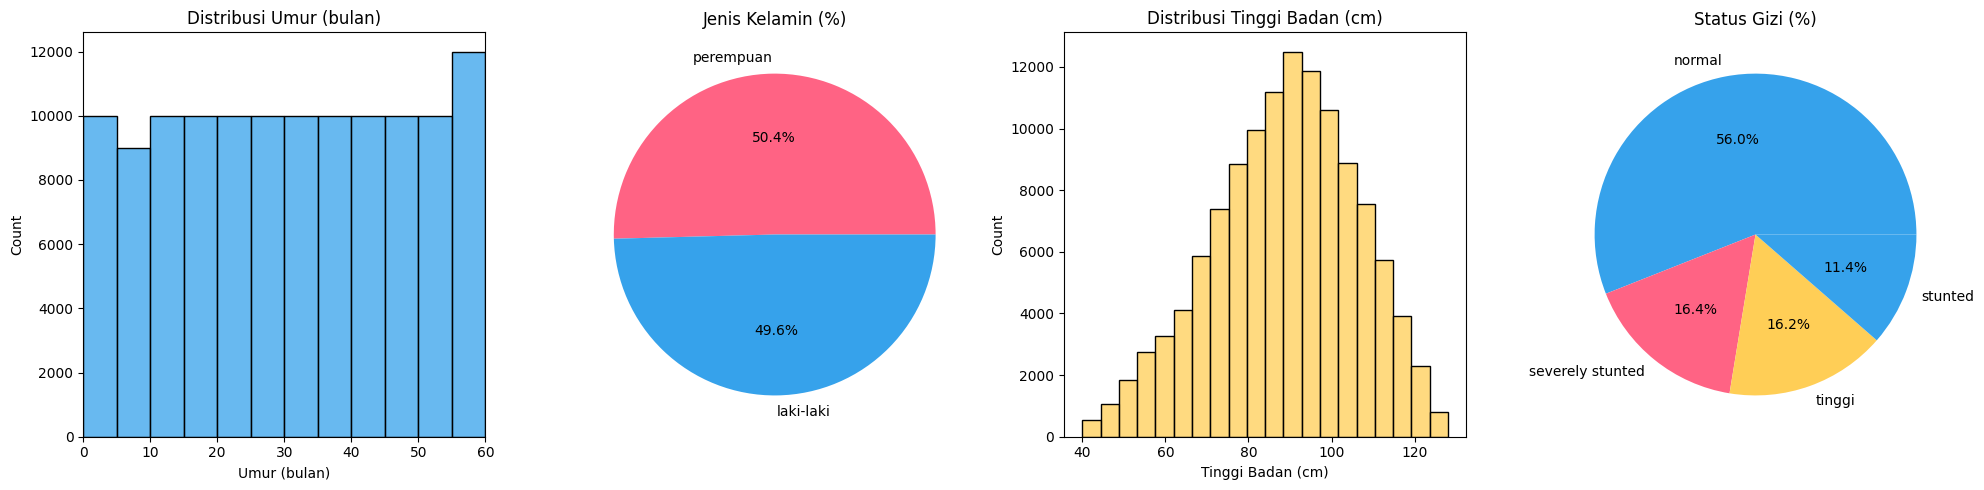

In [57]:
df = pd.read_csv(filename)

# Membaca data dari file CSV
df = pd.read_csv('data/data_balita.csv')

# Membuat figure dengan 4 subplot sejajar
plt.figure(figsize=(20, 5))

# 1. Histogram untuk Umur (bulan)
plt.subplot(1, 4, 1)
sns.histplot(data=df, x='Umur (bulan)', bins=12, color='#36A2EB')
plt.title('Distribusi Umur (bulan)')
plt.xlabel('Umur (bulan)')
plt.ylabel('Count')
plt.xlim(0, 60)

# 2. Pie Chart untuk Jenis Kelamin
plt.subplot(1, 4, 2)
jenis_kelamin_counts = df['Jenis Kelamin'].value_counts()
plt.pie(jenis_kelamin_counts, labels=jenis_kelamin_counts.index, autopct='%1.1f%%', colors=['#FF6384', '#36A2EB'])    
plt.title('Jenis Kelamin (%)')

# 3. Histogram untuk Tinggi Badan (cm)
plt.subplot(1, 4, 3)
sns.histplot(data=df, x='Tinggi Badan (cm)', bins=20, color='#FFCE56')
plt.title('Distribusi Tinggi Badan (cm)')
plt.xlabel('Tinggi Badan (cm)')
plt.ylabel('Count')

# 4. Pie Chart untuk Status Gizi
plt.subplot(1, 4, 4)
status_gizi_counts = df['Status Gizi'].value_counts()
plt.pie(status_gizi_counts, labels=status_gizi_counts.index, autopct='%1.1f%%', colors=['#36A2EB', '#FF6384', '#FFCE56'])
plt.title('Status Gizi (%)')

# Menyesuaikan tata letak
plt.tight_layout()
plt.show()

# Fungsi aktivasi


In [58]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


# Fungsi loss: Categorical crossentropy


In [59]:
def categorical_crossentropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # Hindari log(0)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]


# Inisialisasi bobot dan bias


In [60]:
def initialize_weights(input_dim, hidden1_dim, hidden2_dim, output_dim):
    np.random.seed(42)
    W1 = np.random.randn(input_dim, hidden1_dim) * 0.01
    b1 = np.zeros((1, hidden1_dim))
    W2 = np.random.randn(hidden1_dim, hidden2_dim) * 0.01
    b2 = np.zeros((1, hidden2_dim))
    W3 = np.random.randn(hidden2_dim, output_dim) * 0.01
    b3 = np.zeros((1, output_dim))
    return W1, b1, W2, b2, W3, b3


# Forward pass


In [61]:
def forward_pass(X, W1, b1, W2, b2, W3, b3):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = relu(Z2)
    Z3 = np.dot(A2, W3) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3


# Backward pass


In [62]:
def backward_pass(X, y, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, b1, b2, b3, learning_rate):
    m = X.shape[0]
    
    # Gradien output layer
    dZ3 = A3 - y
    dW3 = np.dot(A2.T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m
    
    # Gradien hidden layer 2
    dA2 = np.dot(dZ3, W3.T)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    
    # Gradien hidden layer 1
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    # Update bobot dan bias
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    
    return W1, b1, W2, b2, W3, b3

# Memuat dan memproses data


In [63]:
def load_and_preprocess_data(filename):
    try:
        # Membaca CSV dengan delimiter koma
        df = pd.read_csv(filename, delimiter=',')

        # Debugging: Cetak nama kolom dan 5 baris pertama
        print("Nama kolom dalam dataset:", df.columns.tolist())
        print("5 baris pertama dataset:\n", df.head())

        # Menghapus baris dengan nilai kosong
        df = df.dropna()

        # Periksa kolom yang diperlukan
        required_columns = ['Umur (bulan)', 'Jenis Kelamin', 'Tinggi Badan (cm)', 'Status Gizi']
        for col in required_columns:
            if col not in df.columns:
                raise KeyError(f"Kolom '{col}' tidak ditemukan. Kolom yang tersedia: {df.columns.tolist()}")

        # Encoding Jenis Kelamin
        df['Jenis Kelamin'] = df['Jenis Kelamin'].map({'laki-laki': 0, 'perempuan': 1})
        if df['Jenis Kelamin'].isnull().any():
            raise ValueError("Terdapat nilai null di kolom 'Jenis Kelamin' setelah encoding.")

        # Encoding Status Gizi
        label_encoder = LabelEncoder()
        df['Status Gizi Encoded'] = label_encoder.fit_transform(df['Status Gizi'])
        status_gizi_classes = label_encoder.classes_

        # One-hot encoding untuk Status Gizi
        y = np.zeros((df.shape[0], len(status_gizi_classes)))
        for i, label in enumerate(df['Status Gizi Encoded']):
            y[i, label] = 1

        # Memilih fitur
        X = df[['Umur (bulan)', 'Jenis Kelamin', 'Tinggi Badan (cm)']].values

        # Normalisasi fitur numerik
        scaler = MinMaxScaler()
        X[:, [0, 2]] = scaler.fit_transform(X[:, [0, 2]])

        return X, y, status_gizi_classes, scaler
    except Exception as e:
            print(f"Error saat memproses data: {e}")
            raise

# Proses input pengguna


In [64]:
def process_user_input(umur, jenis_kelamin, tinggi_badan, max_umur, max_tinggi):
    jenis_kelamin_map = {'laki-laki': 0, 'perempuan': 1}
    jenis_kelamin_num = jenis_kelamin_map.get(jenis_kelamin.lower())
    if jenis_kelamin_num is None:
        raise ValueError("Jenis Kelamin harus 'laki-laki' atau 'perempuan'")
    
    user_input = np.array([[umur, jenis_kelamin_num, tinggi_badan]])
    user_input[:, 0] = user_input[:, 0] / max_umur
    user_input[:, 2] = user_input[:, 2] / max_tinggi
    return user_input


# Prediksi interaktif


In [65]:
def predict_interactive(W1, b1, W2, b2, W3, b3, status_gizi_classes, max_umur, max_tinggi):
    while True:
        try:
            print("\nMasukkan data balita untuk prediksi (atau ketik 'keluar' untuk berhenti):")
            umur_input = input("Umur (bulan): ")
            if umur_input.lower() == 'keluar':
                break
            umur = float(umur_input)
            jenis_kelamin = input("Jenis Kelamin (laki-laki/perempuan): ")
            tinggi_badan = float(input("Tinggi Badan (cm): "))
            
            # Proses input pengguna
            user_input = process_user_input(umur, jenis_kelamin, tinggi_badan, max_umur, max_tinggi)
            
            # Forward pass untuk prediksi
            _, _, _, _, _, A3 = forward_pass(user_input, W1, b1, W2, b2, W3, b3)
            predicted_class = status_gizi_classes[np.argmax(A3)]
            print(f'\nPrediksi Status Gizi: {predicted_class}')
            
        except ValueError as e:
            print(f"Error: {e}. Silakan masukkan data yang valid.")
        except Exception as e:
            print(f"Terjadi kesalahan: {e}. Silakan coba lagi.")

# Visualisasi prediksi

In [66]:
X, y, status_gizi_classes, scaler = load_and_preprocess_data(filename)

# Menyimpan nilai maksimum untuk normalisasi
max_umur = X[:, 0].max() * 60
max_tinggi = X[:, 2].max() * 127.9

# Setelah normalisasi data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Simpan scaler
dump(scaler, 'model/scaler.joblib')
print("Scaler telah disimpan sebagai 'scaler.joblib'")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi bobot
input_dim = X.shape[1]
hidden1_dim = 64
hidden2_dim = 32
output_dim = y.shape[1]
W1, b1, W2, b2, W3, b3 = initialize_weights(input_dim, hidden1_dim, hidden2_dim, output_dim)

# Debugging: Pastikan bobot diinisialisasi dengan benar
print("\nDimensi bobot dan bias:")
print(f"W1: {W1.shape}, b1: {b1.shape}")
print(f"W2: {W2.shape}, b2: {b2.shape}")
print(f"W3: {W3.shape}, b3: {b3.shape}")


Nama kolom dalam dataset: ['Umur (bulan)', 'Jenis Kelamin', 'Tinggi Badan (cm)', 'Status Gizi']
5 baris pertama dataset:
    Umur (bulan) Jenis Kelamin  Tinggi Badan (cm)       Status Gizi
0             0     laki-laki          44.591973           stunted
1             0     laki-laki          56.705203            tinggi
2             0     laki-laki          46.863358            normal
3             0     laki-laki          47.508026            normal
4             0     laki-laki          42.743494  severely stunted
Scaler telah disimpan sebagai 'scaler.joblib'

Dimensi bobot dan bias:
W1: (3, 64), b1: (1, 64)
W2: (64, 32), b2: (1, 32)
W3: (32, 4), b3: (1, 4)


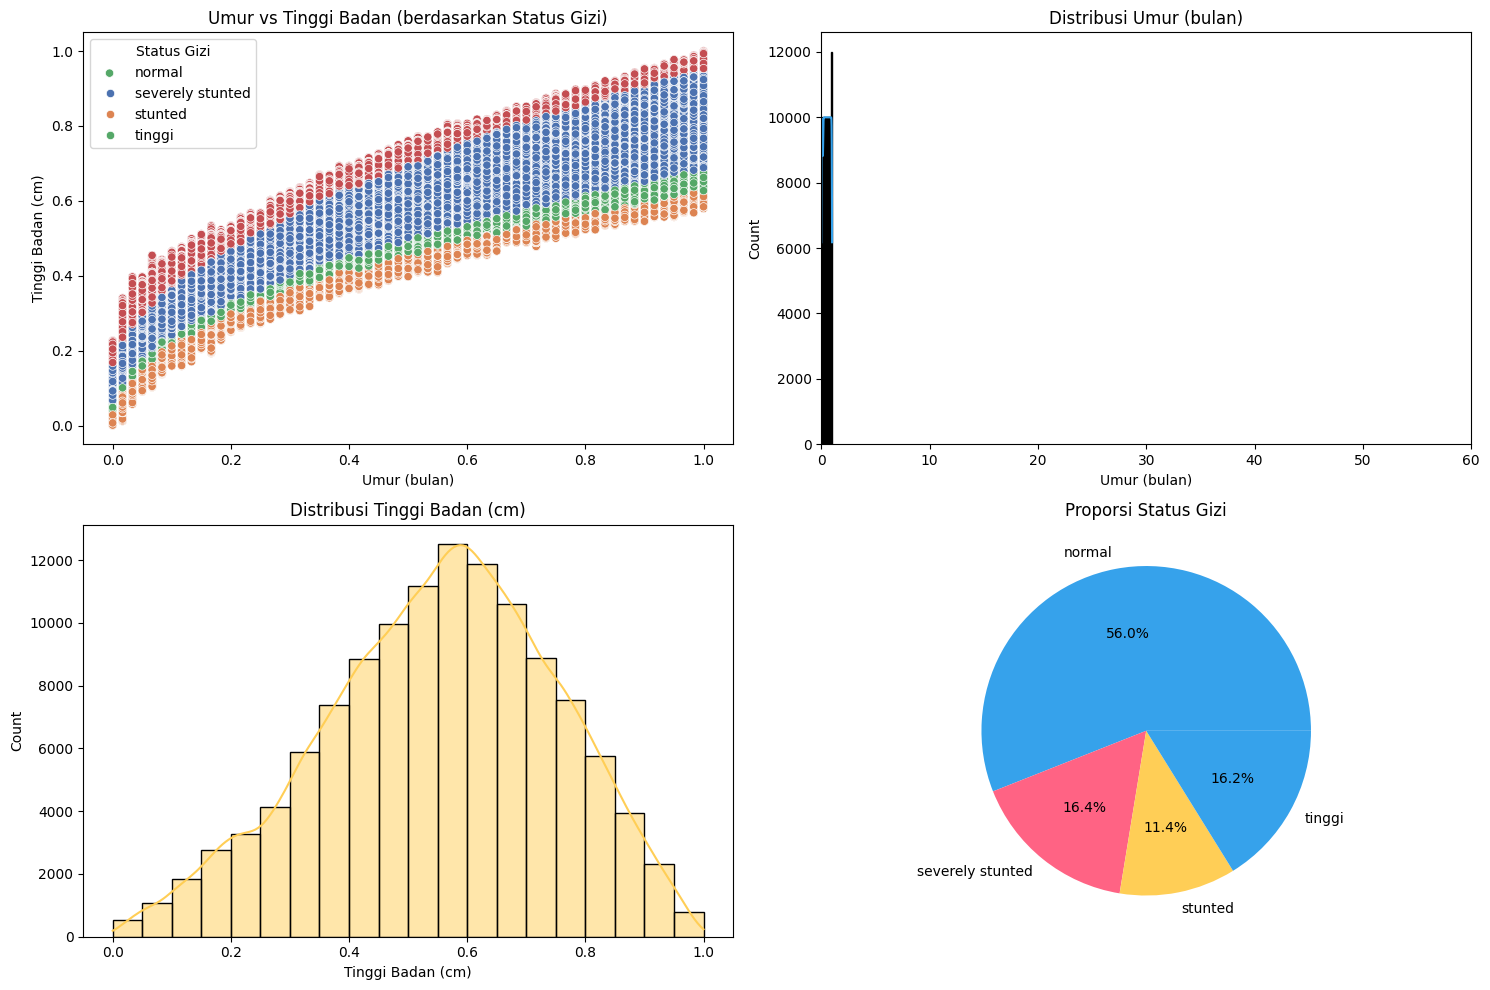

In [67]:
plt.figure(figsize=(15, 10))

# 1. Scatter Plot: Umur vs Tinggi Badan (dengan warna berdasarkan Status Gizi)
plt.subplot(2, 2, 1)
status_gizi_encoded = np.argmax(y, axis=1)  # Konversi one-hot ke label
sns.scatterplot(data=pd.DataFrame(X, columns=['Umur (bulan)', 'Jenis Kelamin', 'Tinggi Badan (cm)']),
                x='Umur (bulan)', y='Tinggi Badan (cm)', hue=status_gizi_encoded, palette='deep')
plt.title('Umur vs Tinggi Badan (berdasarkan Status Gizi)')
plt.xlabel('Umur (bulan)')
plt.ylabel('Tinggi Badan (cm)')
plt.legend(title='Status Gizi', labels=status_gizi_classes)

# 2. Histogram untuk Umur (bulan) dengan KDE
plt.subplot(2, 2, 2)
sns.histplot(data=pd.DataFrame(X, columns=['Umur (bulan)', 'Jenis Kelamin', 'Tinggi Badan (cm)']),
             x='Umur (bulan)', bins=12, kde=True, color='#36A2EB')
plt.title('Distribusi Umur (bulan)')
plt.xlabel('Umur (bulan)')
plt.ylabel('Count')
plt.xlim(0, 60)

# 3. Histogram untuk Tinggi Badan (cm) dengan KDE
plt.subplot(2, 2, 3)
sns.histplot(data=pd.DataFrame(X, columns=['Umur (bulan)', 'Jenis Kelamin', 'Tinggi Badan (cm)']),
             x='Tinggi Badan (cm)', bins=20, kde=True, color='#FFCE56')
plt.title('Distribusi Tinggi Badan (cm)')
plt.xlabel('Tinggi Badan (cm)')
plt.ylabel('Count')

# 4. Pie Chart untuk Status Gizi
plt.subplot(2, 2, 4)
status_gizi_counts = np.sum(y, axis=0)
plt.pie(status_gizi_counts, labels=status_gizi_classes, autopct='%1.1f%%', colors=['#36A2EB', '#FF6384', '#FFCE56'])
plt.title('Proporsi Status Gizi')

# Menyesuaikan tata letak
plt.tight_layout()
plt.show()

# Pelatihan


In [68]:
# pelatihan model
epochs = 50
batch_size = 32
learning_rate = 0.01
num_batches = X_train.shape[0] // batch_size

loss_history = []
accuracy_history = []

for epoch in range(epochs):
    # Mini-batch gradient descent
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        # Forward pass
        Z1, A1, Z2, A2, Z3, A3 = forward_pass(X_batch, W1, b1, W2, b2, W3, b3)
        
        # Hitung loss
        loss = categorical_crossentropy(y_batch, A3)
        
        # Backward pass
        W1, b1, W2, b2, W3, b3 = backward_pass(X_batch, y_batch, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, b1, b2, b3, learning_rate)
    
    # Evaluasi pada data testing setiap epoch
    _, _, _, _, _, A3_test = forward_pass(X_test, W1, b1, W2, b2, W3, b3)
    loss_test = categorical_crossentropy(y_test, A3_test)
    accuracy = np.mean(np.argmax(A3_test, axis=1) == np.argmax(y_test, axis=1))

    # Simpan history
    loss_history.append(loss_test)
    accuracy_history.append(accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss_test:.4f}, Accuracy: {accuracy:.4f}')



Epoch 1/50, Loss: 1.1727, Accuracy: 0.5530
Epoch 2/50, Loss: 1.1727, Accuracy: 0.5530
Epoch 3/50, Loss: 1.1727, Accuracy: 0.5530
Epoch 4/50, Loss: 1.1727, Accuracy: 0.5530
Epoch 5/50, Loss: 1.1727, Accuracy: 0.5530
Epoch 6/50, Loss: 1.1727, Accuracy: 0.5530
Epoch 7/50, Loss: 1.1727, Accuracy: 0.5530
Epoch 8/50, Loss: 1.1726, Accuracy: 0.5530
Epoch 9/50, Loss: 1.1726, Accuracy: 0.5530
Epoch 10/50, Loss: 1.1726, Accuracy: 0.5530
Epoch 11/50, Loss: 1.1726, Accuracy: 0.5530
Epoch 12/50, Loss: 1.1726, Accuracy: 0.5530
Epoch 13/50, Loss: 1.1725, Accuracy: 0.5530
Epoch 14/50, Loss: 1.1724, Accuracy: 0.5530
Epoch 15/50, Loss: 1.1721, Accuracy: 0.5530
Epoch 16/50, Loss: 1.1710, Accuracy: 0.5530
Epoch 17/50, Loss: 1.1653, Accuracy: 0.5530
Epoch 18/50, Loss: 1.1381, Accuracy: 0.5530
Epoch 19/50, Loss: 1.0413, Accuracy: 0.5703
Epoch 20/50, Loss: 0.7368, Accuracy: 0.6729
Epoch 21/50, Loss: 0.6050, Accuracy: 0.7659
Epoch 22/50, Loss: 0.4227, Accuracy: 0.8525
Epoch 23/50, Loss: 0.2884, Accuracy: 0.91

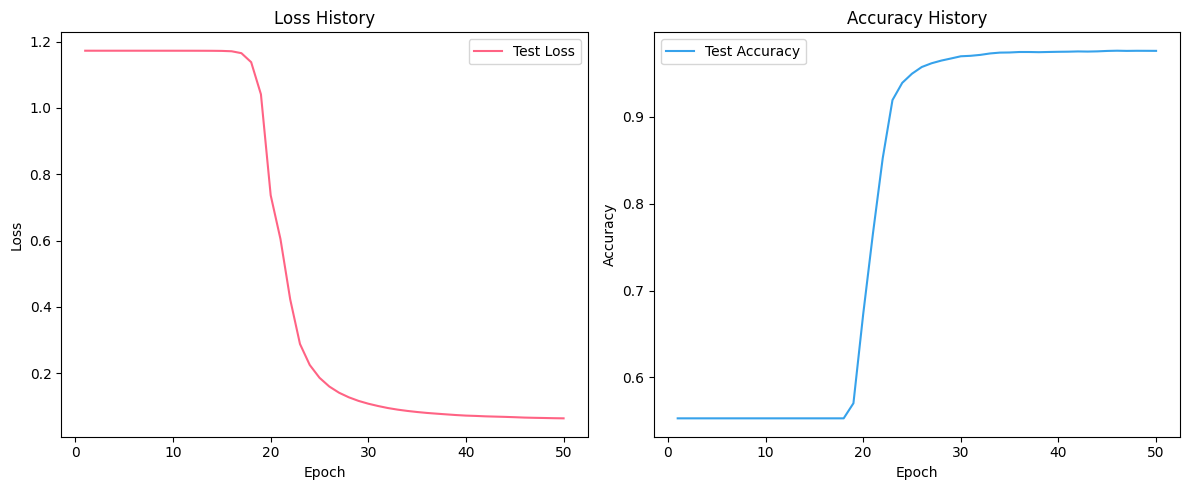

In [69]:
# Visualisasi history
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), loss_history, color='#FF6384', label='Test Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracy_history, color='#36A2EB', label='Test Accuracy')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# # Prediksi interaktif
# print("\nModel telah dilatih. Sekarang Anda dapat memasukkan data untuk prediksi.")
# predict_interactive(W1, b1, W2, b2, W3, b3, status_gizi_classes, max_umur, max_tinggi)


Masukkan data balita untuk prediksi (atau ketik 'keluar' untuk berhenti):
